In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import stanza 

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, classification_report

Previous Enron Cleaning Notebook needs to be run before this.

In [125]:
training_df = pd.read_pickle('../Data/training_df.pkl')

In [126]:
training_df.head(2)

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,Cc,Bcc,Message
293762,01-01-1997 09:22:03,laurinh@prodigy.net,m..love@enron.com,item#1065594740,"""laurin hayes"" <laurinh@prodigy.net>@enron","love, phillip m. </o=enron/ou=na/cn=recipients...",ebay customer support <queue@ebay.com>,,queue@ebay.com,queue@ebay.com,\nIt's clear the Ebay made the error in this ...
22451,01-01-2000 06:36:00,sally.beck@enron.com,fernley.dyson@enron.com,Happy New Year - No Y2K Fear!,sally beck,fernley dyson,,,NaN,NaN,We are wrapping up several hours in the office...


In [127]:
#take only emails and create new df for manipulation
data = pd.DataFrame(training_df['Message'].copy())
data.columns=['email']

In [128]:
data.head()

,email
293762,\nIt's clear the Ebay made the error in this ...
22451,We are wrapping up several hours in the office...
125372,"email problems, No temps yet, same as for cast\n"
284821,VITA Volunteers The Volunteer Income Tax Assis...
3064,"if we were open today, where would you open it?"


Loading in NLTK and Stanza

In [6]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
analyzer = SentimentIntensityAnalyzer()

In [8]:
nlp = stanza.Pipeline(lang='en',processors='tokenize,sentiment')

2022-09-10 23:22:50 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-09-10 23:22:50 INFO: Use device: cpu
2022-09-10 23:22:50 INFO: Loading: tokenize
2022-09-10 23:22:50 INFO: Loading: sentiment
2022-09-10 23:22:51 INFO: Done loading processors!


In [9]:
doc_0 = data.email.iloc[0]

In [10]:
print(doc_0)


It's clear the Ebay made the error in this  matter.
They are not being forthcoming about it however. I'am  continuing to communicate with them but they are being less that  honest.
I am not going to pay what I did not bid.
Since Ebay is the culprit here we are caught in the middle  
I'd refrain from leaving any negative at my site, until this  matter can be resolved, since I would have to respond in  kind.


There coincidentally happened to be a mistake in this email (an actual human typo of 'that' instead of 'than' in the second line). This affects the sentiment results. The correction is made below to highlight this.

In [11]:
doc_corr = '''\nIt's clear the Ebay made the error in this  matter.\nThey are not being forthcoming about it however. I'am  continuing to communicate with them but they are being less than honest.\nI am not going to pay what I did not bid.\nSince Ebay is the culprit here we are caught in the middle  \nI'd refrain from leaving any negative at my site, until this  matter can be resolved, since I would have to respond in  kind.'''

In [129]:
#stanza sentiment analyzer for each sentence and average
def stanza_analyzer_iter(doc):
    doc = nlp(doc)
    sentiment=0
    for sentence in doc.sentences:
        print(sentence.text)
        #stanza returns 0,1,2 for neg,neu,pos respectively
        #however -1,0,1 for neg,neu, pos makes more sense
        ss=sentence.sentiment-1
        sentiment+=ss
        print(ss)
        print()
    print('**Average Sentiment**   :', sentiment/len(doc.sentences))

In [130]:
#vader sentiment analyzer for each sentence and average
def vader_analyzer_iter(doc):
    sentences = tokenize.sent_tokenize(doc)
    sentiment=0
    for sentence in sentences:
        ss = analyzer.polarity_scores(sentence)['compound']
        sentiment+=ss
        print(sentence)
        print(ss)
        print()
    print('**Average Sentiment**   :',sentiment/len(sentences))

Results on doc with and without error:

In [131]:
stanza_analyzer_iter(doc_0)

It's clear the Ebay made the error in this  matter.
0

They are not being forthcoming about it however.
0

I'am  continuing to communicate with them but they are being less that  honest.
1

I am not going to pay what I did not bid.
-1

Since Ebay is the culprit here we are caught in the middle  
I'd refrain from leaving any negative at my site, until this  matter can be resolved, since I would have to respond in  kind.
-1

**Average Sentiment**   : -0.2


In [132]:
stanza_analyzer_iter(doc_corr)

It's clear the Ebay made the error in this  matter.
0

They are not being forthcoming about it however.
0

I'am  continuing to communicate with them but they are being less than honest.
-1

I am not going to pay what I did not bid.
-1

Since Ebay is the culprit here we are caught in the middle  
I'd refrain from leaving any negative at my site, until this  matter can be resolved, since I would have to respond in  kind.
-1

**Average Sentiment**   : -0.6


Stanza result goes from -0.2 ('Slightly Negative') to -0.6 ('Very Negative')

For VADER:

In [210]:
vader_analyzer_iter(doc_0)


It's clear the Ebay made the error in this  matter.
0.0

They are not being forthcoming about it however.
0.0

I'am  continuing to communicate with them but they are being less that  honest.
0.6165

I am not going to pay what I did not bid.
0.0762

Since Ebay is the culprit here we are caught in the middle  
I'd refrain from leaving any negative at my site, until this  matter can be resolved, since I would have to respond in  kind.
0.1343

**Average Sentiment**   : 0.16540000000000002


In [211]:
vader_analyzer_iter(doc_corr)


It's clear the Ebay made the error in this  matter.
0.0

They are not being forthcoming about it however.
0.0

I'am  continuing to communicate with them but they are being less than honest.
0.6165

I am not going to pay what I did not bid.
0.0762

Since Ebay is the culprit here we are caught in the middle  
I'd refrain from leaving any negative at my site, until this  matter can be resolved, since I would have to respond in  kind.
0.1343

**Average Sentiment**   : 0.16540000000000002


VADER sentiment stays exactly the same. Stanza seems more robust in understanding that this email specifically is Negative, while VADER sees it as 'Slightly Positive'.

### Adding Sentiment to DataFrame

In [14]:
#vader analyzer returning only average sentiment
def vader_analyzer(doc):
    analyzer = SentimentIntensityAnalyzer()
    sentences = tokenize.sent_tokenize(doc)
    avg_sent = sum([analyzer.polarity_scores(sentence)['compound']
                    for sentence in sentences])/len(sentences)
    
    return avg_sent

In [15]:
#stanza analyzer returning only average sentiment
def stanza_analyzer(doc):
    doc = nlp(doc)
    avg_sent = sum([sentence.sentiment-1
                   for sentence in doc.sentences])/len(doc.sentences)
    
    return avg_sent

Code below is commented out because it takes *A LONG TIME* to run. The VADER section took \~1100 seconds (<20 minutes) but the Stanza section takes \~36,000 seconds (~10 hours). This will obviously vary between devices.

In [31]:
# v_start = time.time()
# data['vader_sentiment'] = np.vectorize(vader_analyzer)(data['email'])
# v_end = time.time()
# print('Vader runtime:', v_end-v_start)

# s_start = time.time()
# data['stanza_sentiment'] = np.vectorize(stanza_analyzer)(data['email'])
# s_end = time.time()
# print('Stanza runtime:', s_end-s_start)

Vader runtime: 1110.7918484210968
Stanza runtime: 36083.866980314255


Save DataFrame for easier loading-in later

In [46]:
data.to_csv('../Data/savedsent.csv')

Load DataFrame

In [136]:
data = pd.read_csv('../Data/savedsent.csv')

### Creating Sentiment Bins

Setting the sentiment score of $[-0.05,0.05]$ to be assigned for neutral emails, we then equidistantly space $[-1,-0.05)$ for Negative intensities, and the same for Positives.

In [142]:
neg_sent_bins = np.linspace(-1,-0.05,5)[1:]
neg_sent_bins

array([-0.7625, -0.525 , -0.2875, -0.05  ])

Anything below:
 - -0.7625 is Extremely Negative, 
 - -0.525 is Very Negative,
 - -0.2875 is Moderately Negative,
 - -0.05 is Slightly Negative.

We do the same for positives.

In [143]:
pos_sent_bins = -neg_sent_bins[0:]
pos_sent_bins

array([0.7625, 0.525 , 0.2875, 0.05  ])

In [144]:
#merge the range of neg->pos
sb=np.append(pos_sent_bins,np.flip(neg_sent_bins))
sb

array([ 0.7625,  0.525 ,  0.2875,  0.05  , -0.05  , -0.2875, -0.525 ,
       -0.7625])

In [140]:
#create desired order of intensity
s_intensity = ['Extremely','Very','Moderately','Slightly']
s_label = ['Positive','Negative']
#iterate intensity,sent
s_order = [intensity+' '+label for label in s_label[::-1] for intensity in s_intensity]
#add neutral in middle
s_order.insert(4,'Neutral')

In [146]:
#preview
s_order

['Extremely Negative',
 'Very Negative',
 'Moderately Negative',
 'Slightly Negative',
 'Neutral',
 'Slightly Positive',
 'Moderately Positive',
 'Very Positive',
 'Extremely Positive']

In [147]:
s_label

['Positive', 'Negative']

In [148]:
import math

Testing selection method

In [149]:
[0.9>x for x in pos_sent_bins]

[True, True, True, True]

In [150]:
[0.9>x for x in pos_sent_bins].index(True)

0

In [151]:
s_intensity[0]

'Extremely'

Create function to turn sentiment score into sentiment intensity bin

In [113]:
def sentimentLabel(sentiment):
    abs_sent = abs(sentiment)
    
    if abs_sent<=0.05: #treat neutral range separately
        return 'Neutral'
    else:
        #if the sentiment is negative, math.ceil(sent)-1=-1
        #if the sentiment is negative, math.ceil(sent)-1=0
        #sent/2 is a way to handle cases where sent == -1 or sent == 1 exactly
        i = math.ceil(sentiment/2)-1
        #grab positive or negative index from s_label
        label = s_label[i]
        #grab intensity from pos_sent_bins (intensity is symmetrical)
        ii = [abs_sent>x for x in pos_sent_bins].index(True)
        intensity = s_intensity[ii]
        
        return '{} {}'.format(intensity,label)

Append bins to DataFrame

In [114]:
data['vader_sentiment_bin'] = np.vectorize(sentimentLabel)(data['vader_sentiment'])
data['stanza_sentiment_bin'] = np.vectorize(sentimentLabel)(data['stanza_sentiment'])

In [116]:
data.to_csv('../Data/savedsent.csv',index=False)

In [117]:
data = pd.read_csv('../Data/savedsent.csv')

In [118]:
data.head()

,email,vader_sentiment,stanza_sentiment,vader_sentiment_bin,stanza_sentiment_bin
0,\nIt's clear the Ebay made the error in this ...,0.165400,-0.200000,Slightly Positive,Slightly Negative
1,We are wrapping up several hours in the office...,0.177890,0.100000,Slightly Positive,Slightly Positive
2,"email problems, No temps yet, same as for cast\n",-0.599400,-0.500000,Very Negative,Moderately Negative
3,VITA Volunteers The Volunteer Income Tax Assis...,-0.003654,-0.266667,Neutral,Slightly Negative
4,"if we were open today, where would you open it?",0.000000,0.000000,Neutral,Neutral


## Histogram

Reminder of `s_order` variable

In [48]:
s_order

['Extremely Negative',
 'Very Negative',
 'Moderately Negative',
 'Slightly Negative',
 'Neutral',
 'Slightly Positive',
 'Moderately Positive',
 'Very Positive',
 'Extremely Positive']

Get `value_count` for each sentiment bin (VADER and Stanza), then put them in desired `s_order`

In [49]:
v_sent_dict = data.vader_sentiment_bin.value_counts().to_dict()
s_sent_dict = data.stanza_sentiment_bin.value_counts().to_dict()

ord_vsent_dict= {k:v_sent_dict[k] for k in s_order}
ord_ssent_dict= {k:s_sent_dict[k] for k in s_order}

ord_vsent_dict, ord_ssent_dict

({'Extremely Negative': 87,
  'Very Negative': 240,
  'Moderately Negative': 704,
  'Slightly Negative': 6731,
  'Neutral': 24818,
  'Slightly Positive': 47397,
  'Moderately Positive': 19782,
  'Very Positive': 2858,
  'Extremely Positive': 541},
 {'Extremely Negative': 1909,
  'Very Negative': 1621,
  'Moderately Negative': 14125,
  'Slightly Negative': 29341,
  'Neutral': 39506,
  'Slightly Positive': 11515,
  'Moderately Positive': 4106,
  'Very Positive': 418,
  'Extremely Positive': 617})

In [50]:
for k in ord_vsent_dict:
    print(round(ord_vsent_dict[k]/len(data)*100,2))

0.08
0.23
0.68
6.52
24.06
45.95
19.18
2.77
0.52


In [52]:
len(ddata[ddata['stanza_sentiment']==1]), len(ddata[ddata['stanza_sentiment']==-1])

(584, 1716)

In [53]:
584/len(ddata) 

0.00570858829739399

In [54]:
1716/len(ddata)

0.01677386561357549

Plot histogram of bin frequency

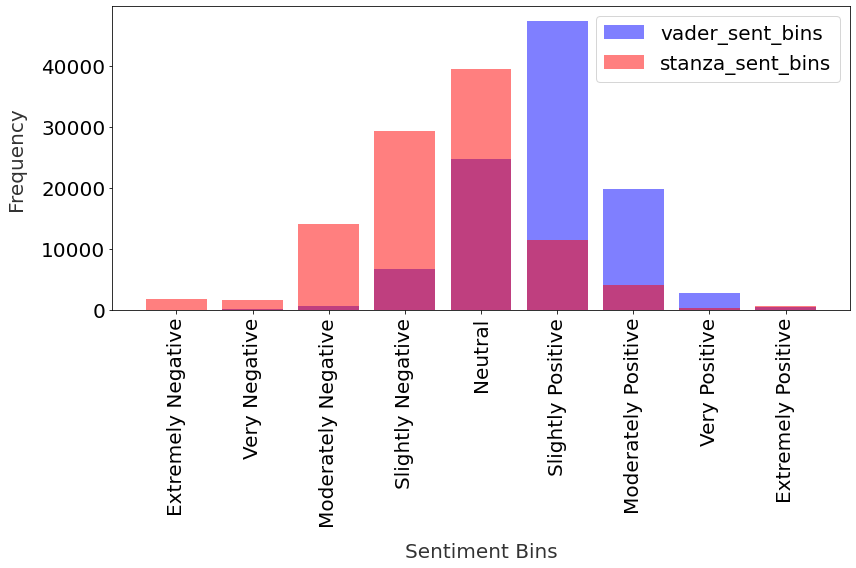

In [70]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(12, 8)

x = ord_vsent_dict.keys()

vy = ord_vsent_dict.values()
sy = ord_ssent_dict.values()

ax.bar(x,vy, color='b',alpha=0.5,label='vader_sent_bins')
ax.bar(x,sy, color='r',alpha=0.5,label='stanza_sent_bins')

plt.xlabel('Sentiment Bins',size=20,labelpad=15, color='#333333')
plt.xticks(rotation='vertical',size=20)

plt.ylabel('Frequency',size=20,labelpad=15, color='#333333')
plt.yticks(size=20)

plt.legend(prop={'size':20})
fig.tight_layout()
fig.savefig('../Data/stanz_vader_bins.png',dpi=200)

plt.show()

Seems to be substantial differences (as we saw by ~40k rows in `rr` DataFrame)

## KDE

sampling idea: find way to approximate density a bit more automatically. currently kde with bandwidth set to 0.0175 seems pretty good (by eye) but could be overfitting. is there a better way to do this other than brute force gradient descent for example?

make mention of maybe expert knowledge and bayesian methods for having priors?

kde code from [here](https://stackoverflow.com/questions/63843884/sample-from-a-distribution-function-in-python)

KDE estimates for each of VADER and Stanza raw sentiment scores

In [61]:
vobs = np.array(data[~data['email'].duplicated()]['vader_sentiment'])
vkde1 = stats.gaussian_kde(vobs)

sobs = np.array(data[~data['email'].duplicated()]['stanza_sentiment'])
skde1 = stats.gaussian_kde(sobs)

x1 = np.linspace(-1, 1, 1000)
vy1 = vkde1.pdf(x1)
sy1 = skde1.pdf(x1)

# vkde2 = KernelDensity(bandwidth=0.1).fit(obs.reshape(-1, 1))
# vy2 = kde2.sample(10**5,random_state=42);

# vkde3 = KernelDensity(bandwidth=0.0175).fit(obs.reshape(-1, 1))
# vy3 = vkde3.sample(10**5,random_state=42);

# vkde3 = KernelDensity(bandwidth=0.0175).fit(obs.reshape(-1, 1))
# vy3 = vkde3.sample(10**5,random_state=42);

# vkde4 = KernelDensity(bandwidth=0.001).fit(obs.reshape(-1, 1))
# y4 = kde4.sample(10**5,random_state=42);

Plotting KDE

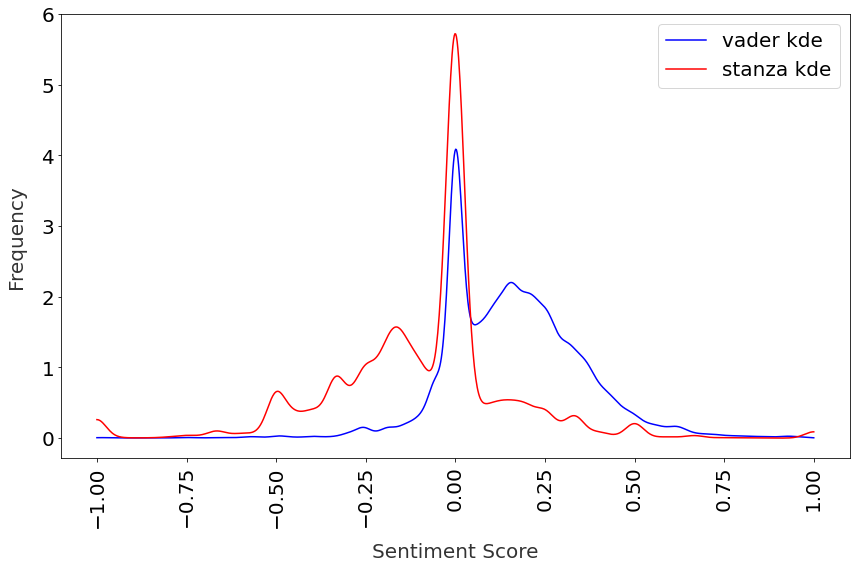

In [69]:
from scipy import stats
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 8)

vline = ax.plot(x1, vy1, c='b',label='vader kde')
# ax.hist(vy2.ravel(), bins=100, density=True, color='r', alpha=0.7);
# ax.hist(vy3.ravel(), bins=100, density=True, color='m', alpha=0.7);
# ax.hist(vy4.ravel(), bins=100, density=True, color='r', alpha=0.7);

sline = ax.plot(x1,sy1,c='r',label = 'stanza kde')
# ax.hist(sy3.ravel(), bins=100, density=True, color='c', alpha=0.7);

plt.xlabel('Sentiment Score',size=20,labelpad=15, color='#333333')
plt.xticks(rotation='vertical',size=20)

plt.ylabel('Frequency',size=20,labelpad=15, color='#333333')
plt.yticks(size=20)

plt.legend(prop={'size':20})

fig.tight_layout()
fig.savefig('../Data/stanz_vader_dist.png',dpi=150)

plt.show()

Checking sent score sampling

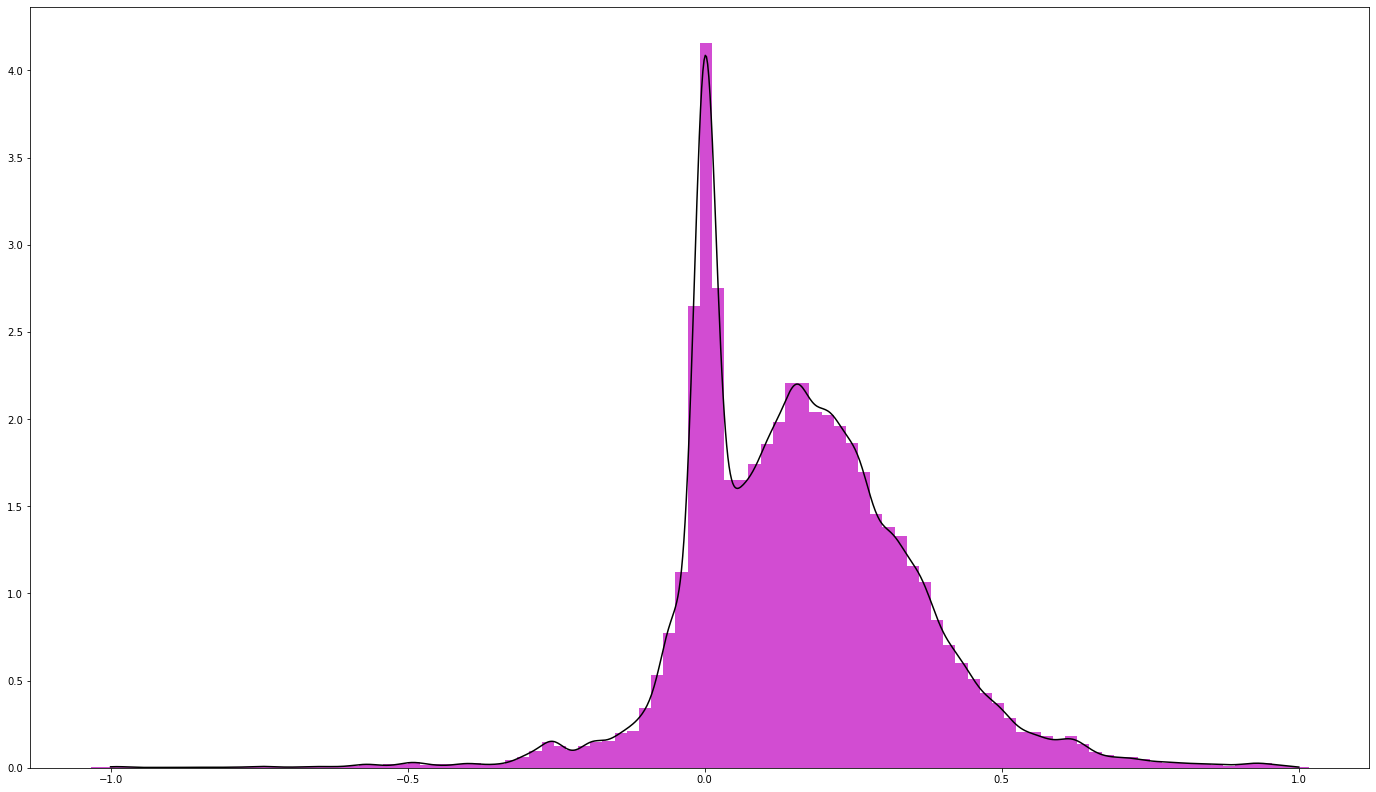

In [87]:
fig, ax = plt.subplots(figsize=(24,14))
ax.plot(x1, vy1, c='black')
# ax.hist(vy2.ravel(), bins=100, density=True, color='r', alpha=0.7);
ax.hist(vy3.ravel(), bins=100, density=True, color='m', alpha=0.7);
# ax.hist(vy4.ravel(), bins=100, density=True, color='r', alpha=0.7);

# ax.plot(x1,sy1,c='blue')
# ax.hist(sy3.ravel(), bins=100, density=True, color='c', alpha=0.7);

In [96]:
sample1=kde1.resample(size=10**5)
sample2=kde2.sample(n_samples=10**5)
sample3=kde3.sample(n_samples=10**5)

In [98]:
for i in range(1,4):
    k = locals()['sample{}'.format(i)]
    print('Sample {} min.:'.format(i),k.min(),'Sample {} max.:'.format(i),k.max())

Sample 1 min.: -1.0304356797476546 Sample 1 max.: 1.0263327955552521
Sample 2 min.: -1.1834379175276741 Sample 2 max.: 1.1662116639080349
Sample 3 min.: -1.0252229439121836 Sample 3 max.: 1.001270945921117


KDE unconstrained so vales>1 and values<-1 appear which is undesirable.

# Exploration, Can Ignore

Sub-select non-duplicated rows

In [119]:
ddata = data[~data.duplicated('email')].sort_values(by='vader_sentiment')

Look at all non-duplicated email rows where Stanza and VADER disagree by at least one sentiment bin.

Note: sentiment bin width is 0.2375, neutral width is 0.05 either side, score difference of 0.28 is just a nice middle ground to use for a difference of at least one sentiment bin, plus some uncertainty.

In [120]:
rr = ddata[abs(ddata.vader_sentiment-ddata.stanza_sentiment)>0.28].copy()
rr['abs_diff'] = np.vectorize(abs)(rr.vader_sentiment-rr.stanza_sentiment)
rr = rr.sort_values(by='abs_diff')
rr

,email,vader_sentiment,stanza_sentiment,vader_sentiment_bin,stanza_sentiment_bin,abs_diff
10042,Met today w/ Causey and Sally to discuss Doors...,0.080011,-0.200000,Slightly Positive,Slightly Negative,0.280011
95622,I thought that you might be interested in our ...,0.189109,-0.090909,Slightly Positive,Slightly Negative,0.280018
78408,I sent that file to you in error. Please disre...,0.030033,-0.250000,Neutral,Slightly Negative,0.280033
10039,I've done some research in relation to securin...,0.106133,-0.173913,Slightly Positive,Slightly Negative,0.280046
71618,Due to the U. S. and London markets being clos...,0.280050,0.000000,Slightly Positive,Neutral,0.280050
...,...,...,...,...,...,...
34561,"\n\n(A) ""Independent Amount"" means with respe...",0.877967,-1.000000,Extremely Positive,Extremely Negative,1.877967
51370,Liz called and they are inviting us over Sat n...,0.880900,-1.000000,Extremely Positive,Extremely Negative,1.880900
16483,\n\n\n868055\t6/20/01\tEnron Energy Services\t...,0.992200,-0.913043,Extremely Positive,Extremely Negative,1.905243
24849,Free Quote\n Double Your Life Insurance For FR...,0.907500,-1.000000,Extremely Positive,Extremely Negative,1.907500


In [121]:
len(rr)/len(ddata)

0.420109088776368

In [122]:
pos_sent_bins

array([0.7625, 0.525 , 0.2875, 0.05  ])

Ignored the cases where the email is seen as Neutral by VADER or Stanza (idea being that Neutral emails can sometimes have weird traits). This is just an exploration stage and will look at Neutral emails later.

In [123]:
rr[(rr.vader_sentiment_bin!='Neutral') & (rr.stanza_sentiment_bin!='Neutral')]

,email,vader_sentiment,stanza_sentiment,vader_sentiment_bin,stanza_sentiment_bin,abs_diff
10042,Met today w/ Causey and Sally to discuss Doors...,0.080011,-0.200000,Slightly Positive,Slightly Negative,0.280011
95622,I thought that you might be interested in our ...,0.189109,-0.090909,Slightly Positive,Slightly Negative,0.280018
10039,I've done some research in relation to securin...,0.106133,-0.173913,Slightly Positive,Slightly Negative,0.280046
38277,Hi Vince\n\nI tried dialling you around 3pm UK...,0.180055,-0.100000,Slightly Positive,Slightly Negative,0.280055
35451,Mr. Rosen:\n\nAttached is the form master nett...,0.080060,-0.200000,Slightly Positive,Slightly Negative,0.280060
...,...,...,...,...,...,...
34561,"\n\n(A) ""Independent Amount"" means with respe...",0.877967,-1.000000,Extremely Positive,Extremely Negative,1.877967
51370,Liz called and they are inviting us over Sat n...,0.880900,-1.000000,Extremely Positive,Extremely Negative,1.880900
16483,\n\n\n868055\t6/20/01\tEnron Energy Services\t...,0.992200,-0.913043,Extremely Positive,Extremely Negative,1.905243
24849,Free Quote\n Double Your Life Insurance For FR...,0.907500,-1.000000,Extremely Positive,Extremely Negative,1.907500


Look at the first example of a normal-looking email with significant scoring difference.

In [31]:
small_diff_doc0 = rr.iloc[0]

In [32]:
print(small_diff_doc0.email)

Met today w/ Causey and Sally to discuss Doorstep going forward. Following is 
my goal with this process.  Rick Carson will co-ordinate RAC's efforts in 
this area pulling in other RAC people as required.


- RAC will participate in review to determine which offices will be inspected 
and on what frequency
- RAC will help design and participate as required in inspections
- I will be able to see, through the RAC website, a list of all offices, a 
list of all offices requiring inspection, when an office was inspected, 
findings from that inspection and the follow-up from the findings.
- If follow up is not happening, a "red flagged" reminder notice should be 
issued via email. 

This has been a huge effort and we have to have this going forward. This is 
one ball that can not be dropped. 

Let me know your thoughts if any.

Rick


See what VADER and Stanza analyzers are scoring:

In [33]:
vader_analyzer_iter(small_diff_doc0.email)

Met today w/ Causey and Sally to discuss Doorstep going forward.
0.0

Following is 
my goal with this process.
0.0

Rick Carson will co-ordinate RAC's efforts in 
this area pulling in other RAC people as required.
0.0

- RAC will participate in review to determine which offices will be inspected 
and on what frequency
- RAC will help design and participate as required in inspections
- I will be able to see, through the RAC website, a list of all offices, a 
list of all offices requiring inspection, when an office was inspected, 
findings from that inspection and the follow-up from the findings.
0.4019

- If follow up is not happening, a "red flagged" reminder notice should be 
issued via email.
0.0

This has been a huge effort and we have to have this going forward.
0.3182

This is 
one ball that can not be dropped.
0.0

Let me know your thoughts if any.
0.0

Rick
0.0

**Average Sentiment**   : 0.0800111111111111


In [34]:
stanza_analyzer_iter(small_diff_doc0.email)

Met today w/ Causey and Sally to discuss Doorstep going forward.
0

Following is 
my goal with this process.
0

Rick Carson will co-ordinate RAC's efforts in 
this area pulling in other RAC people as required.
0

- RAC will participate in review to determine which offices will be inspected 
and on what frequency
- RAC will help design and participate as required in inspections
- I will be able to see, through the RAC website, a list of all offices, a 
list of all offices requiring inspection, when an office was inspected, 
findings from that inspection and the follow-up from the findings.
-1

-
0

If follow up is not happening, a "red flagged" reminder notice should be 
issued via email.
-1

This has been a huge effort and we have to have this going forward.
0

This is 
one ball that can not be dropped.
0

Let me know your thoughts if any.
0

Rick
0

**Average Sentiment**   : -0.2


This is an example of why sentiment analysis can be difficult: even looking at this email personally, the decision betwen labelling it Neutral or Slightly Negative seems somewhat arbitrary. VADER scores this Slightly Positive (though only at 0.08 compared to it being Neutral if it was 0.05), Stanza sees it as Slightly Negative.

Seeing what happens with the first 'normal-looking' email in the tail end of DataFrame (top 5 biggest differences)

In [35]:
big_diff_doc = rr.tail().iloc[1]

In [36]:
big_diff_doc

Unnamed: 0                                                         367745
email                   Liz called and they are inviting us over Sat n...
vader_sentiment                                                    0.8809
stanza_sentiment                                                     -1.0
vader_sentiment_bin                                    Extremely Positive
stanza_sentiment_bin                                   Extremely Negative
abs_diff                                                           1.8809
Name: 51370, dtype: object

In [37]:
big_diff_e = big_diff_doc.email
print(big_diff_e)

Liz called and they are inviting us over Sat nite for a very 
low key and relaxing taco night or - they thought maybe you can help them figure out
how to use their grill...since you are the 'grill master'
let me know 
ily
kq


Seeing what VADER and Stanza are scoring:

In [38]:
vader_analyzer_iter(big_diff_e)

Liz called and they are inviting us over Sat nite for a very 
low key and relaxing taco night or - they thought maybe you can help them figure out
how to use their grill...since you are the 'grill master'
let me know 
ily
kq
0.8809

**Average Sentiment**   : 0.8809


In [39]:
stanza_analyzer_iter(big_diff_e)

Liz called and they are inviting us over Sat nite for a very 
low key and relaxing taco night or - they thought maybe you can help them figure out
how to use their grill...since you are the 'grill master'
let me know 
ily
kq
-1

**Average Sentiment**   : -1.0


It seems that the lack of full-stops has made the analyzers think that the email is only a single sentence, thus scoring it inaccurately. VADER somehow sees this as Extremely Positive (possibly due to it recognising *'ily'* under *'love'*, and the presence of the word *'relaxing'*). Stanza sees this as Extremely Negaitve: maybe the quotation marks around *'grill master'* imply sacasm to Stanza and it does not pick up slang terms such as *'ily'*.

We (for the sake of exploration, not troubleshooting) see what this would look like if all newline-delimiters were replaced by full-stops to create multiple sentences.

In [41]:
fix_doc = big_diff_e.replace(' \n','. ')
fix_doc = fix_doc.replace('\n','. ')
fix_doc

"Liz called and they are inviting us over Sat nite for a very. low key and relaxing taco night or - they thought maybe you can help them figure out. how to use their grill...since you are the 'grill master'. let me know. ily. kq"

In [42]:
vader_analyzer_iter(fix_doc)

Liz called and they are inviting us over Sat nite for a very.
0.3182

low key and relaxing taco night or - they thought maybe you can help them figure out.
0.5859

how to use their grill...since you are the 'grill master'.
0.0

let me know.
0.0

ily.
0.6597

kq
0.0

**Average Sentiment**   : 0.26063333333333333


In [43]:
stanza_analyzer_iter(fix_doc)

Liz called and they are inviting us over Sat nite for a very.
1

low key and relaxing taco night or - they thought maybe you can help them figure out.
-1

how to use their grill...since you are the 'grill master'.
0

let me know.
0

ily.
0

kq
0

**Average Sentiment**   : 0.0


Both analyzers change significantly.

Actual correct version of sentences (not just replacing every `\n` with `.`)

In [44]:
fix_doc1 = fix_doc.replace('very. ','very ')
fix_doc1 = fix_doc1.replace('out. ','out ')
fix_doc1

"Liz called and they are inviting us over Sat nite for a very low key and relaxing taco night or - they thought maybe you can help them figure out how to use their grill...since you are the 'grill master'. let me know. ily. kq"

In [45]:
vader_analyzer_iter(fix_doc1)

Liz called and they are inviting us over Sat nite for a very low key and relaxing taco night or - they thought maybe you can help them figure out how to use their grill...since you are the 'grill master'.
0.701

let me know.
0.0

ily.
0.6597

kq
0.0

**Average Sentiment**   : 0.340175


VADER scores the same as it did `fix_doc`

In [46]:
stanza_analyzer_iter(fix_doc1)

Liz called and they are inviting us over Sat nite for a very low key and relaxing taco night or - they thought maybe you can help them figure out how to use their grill...since you are the 'grill master'.
-1

let me know.
0

ily.
0

kq
0

**Average Sentiment**   : -0.25


In [47]:
neg_sent_bins

array([-0.7625, -0.525 , -0.2875, -0.05  ])

Stanza changes its mind from 'Neutral' to 'Slightly Negative'

In [335]:
# big_diff2 = rr.tail().iloc[0]
# big_diff2e = big_diff2.email
# big_diff2

In [336]:
# print(big_diff2e)

In [337]:
# stanza_analyzer_iter(big_diff2e)

In [338]:
# vader_analyzer_iter(big_diff2e)

In [339]:
# vader_analyzer(big_diff_doc), stanza_analyzer(big_diff_doc)

In [340]:
# rr.sample(frac=0.001,random_state=42)